# Import

In [24]:
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
import nipype.interfaces.utility as util
from nipype.workflows.fmri.fsl.estimate import create_modelfit_workflow, create_fixed_effects_flow
import glob
#from gilles_workflows import create_fdr_threshold_workflow
import numpy as np
from nipype.algorithms.modelgen import SpecifyModel
from nipype.interfaces import fsl


# Add here the code that creates the BFSL files.
Later, create a def(function) to include in the macro-workflow.


# DATASINK and choose run_list_numbers

In [25]:
datasink = pe.Node(nio.DataSink(), name='datasink')

In [26]:
def set_run_order(first_modality, modality):
    if first_modality == modality:
        run = list(range(2,5))
    else:
        run = list(range(6,10))
    run = list(range(6,10))
    return run


# First level modelfit workflow

In [27]:
first_level_modelfit_workflow = pe.Workflow(name='first_level_modelfit', base_dir='/home/ysalzer1/fMRI/amc_Tactile_Simon_Study/workflow_folders/')

In [28]:
TR = 2.5      

In [29]:
#identity and selector - connected

In [30]:
identity = pe.Node(util.IdentityInterface(fields=['subject_id','modality','condition','first_modality']), name = 'identity')
identity.iterables = [('subject_id',['001']),('modality',['tactile'])]
identity.inputs.condition =  ['congruent','incongruent']
identity.inputs.first_modality = 'visual' #need to connect this to 2016_7_15_making_BFSL_amc_Simon

In [31]:
run_list = pe.Node(util.Function(function=set_run_order,input_names=['modality', 'first_modality'],output_names='run'),
                                            name='run_list')

In [32]:
first_level_modelfit_workflow.connect(identity, 'modality', run_list, 'modality')
first_level_modelfit_workflow.connect(identity, 'first_modality', run_list, 'first_modality')


In [33]:
templates = {'bfsl_files': '/home/ysalzer1/fMRI/amc_Tactile_Simon_Study/sub_{subject_id}/func/{modality}/*{modality}*{run}*.bfsl',
             'epi': '/home/ysalzer1/fMRI/amc_Tactile_Simon_Study/derivatives/preprocessed_data/highpassed_files/_modality_{modality}_subject_id_{subject_id}/_addmean*/*_Simontask_S1_WIP_fmri_epi_vibrotactile_SENSE_{run}_1_dtype_mcf_mask_smooth_mask_gms_tempfilt_maths.nii.gz',
            'mask': '/home/ysalzer1/fMRI/amc_Tactile_Simon_Study/derivatives/preprocessed_data/mask/_modality_{modality}_subject_id_{subject_id}/_dilatemask*/*_Simontask_S1_WIP_fmri_epi_vibrotactile_SENSE_{run}_1_dtype_mcf_bet_thresh_dil.nii.gz',
            'realignment_parameters': '/home/ysalzer1/fMRI/amc_Tactile_Simon_Study/derivatives/preprocessed_data/realigned_files/_modality_{modality}_subject_id_{subject_id}/_realign*/*_Simontask_S1_WIP_fmri_epi_vibrotactile_SENSE_{run}_1_dtype_mcf.nii.gz',
            'functional_run' : '/home/ysalzer1/fMRI/amc_Tactile_Simon_Study/sub_{subject_id}/func/{modality}/*_Simontask_S1_WIP_fmri_epi_vibrotactile_SENSE_{run}_1.nii'}

In [34]:
selector = pe.Node(nio.SelectFiles(templates), name = 'selector') #WAS MapNode, iterfield=['run']
selector.iterables = [('run',[ 6, 7, 8, 9])]

In [35]:
first_level_modelfit_workflow.connect(identity, 'subject_id', selector, 'subject_id')
first_level_modelfit_workflow.connect(run_list, 'run', selector, 'run')
first_level_modelfit_workflow.connect(identity, 'modality', selector, 'modality')


In [36]:
#first_level_modelfit_workflow.connect(run_list, 'run', selector, 'run')

#first_level_modelfit_workflow.connect(identity, 'condition', bfsl_selector, 'condition')

# create_modelfit_workflow

In [37]:
modelfit_workflow = create_modelfit_workflow(name='modelfit')
modelfit_workflow.base_dir = '/home/ysalzer1/fMRI/amc_Tactile_Simon_Study/workflow_folders/'
modelfit_workflow.inputs.inputspec.bases = {'dgamma': {'derivs': True}}  #What is this input "bases" used for?

modelfit_workflow.inputs.inputspec.film_threshold = 1000  #What is film-threshold?
modelfit_workflow.inputs.inputspec.interscan_interval = TR
modelfit_workflow.inputs.inputspec.model_serial_correlations = True  #What is model_serial_correlations?

modelfit_workflow.inputs.inputspec.contrasts = [('incongruent > congruent', 'T', ['_{modality}_run_{run}_incongruent_.bfsl', '_{modality}_run_{run}_incongruent_.bfsl'], [1.0, -1.0])]


In [38]:
first_level_modelfit_workflow.connect(selector, 'functional_run', modelfit_workflow, 'inputspec.functional_data')
#אני לא מבינה, האם זה צריך להיות epiאו  raw.nii????

In [39]:
for i in modelfit_workflow.outputs.outputspec.get():
    first_level_modelfit_workflow.connect(modelfit_workflow, 'outputspec.%s' % i, datasink, '%s' % i)

# SpecifyModel

In [40]:
specifymodel = pe.Node(SpecifyModel(), name='SpecifyModel')

In [41]:
specifymodel.inputs.input_units = 'secs'
specifymodel.inputs.time_repetition = 2.5
specifymodel.inputs.high_pass_filter_cutoff = 128. / (2. * 2.) #נראה לי שגוי - בהשוואה לקוד של  model.py
#first_level_modelfit_workflow.connect(xxx,xxx, specifymodel, 'high_pass_filter_cutoff')
#What is high_pass_filter_cutoff? What should its value be? how is it determined?

In [42]:
first_level_modelfit_workflow.connect(selector, 'bfsl_files', specifymodel, 'event_files')
first_level_modelfit_workflow.connect(selector, 'epi', specifymodel, 'functional_runs')
first_level_modelfit_workflow.connect(selector, 'realignment_parameters', specifymodel, 'realignment_parameters')

#first_level_modelfit_workflow.connect(xxx,xxx, specifymodel, 'outlier_files')
#What are the outlier files? לא מוגדרים
#first_level_modelfit_workflow.connect(xxx,xxx, specifymodel, 'subject_info')
#מה זה? זה לא מוגדר עבורי



In [43]:
first_level_modelfit_workflow.connect(specifymodel,'session_info', modelfit_workflow, 'inputspec.session_info')

In [44]:
from IPython.display import Image
first_level_modelfit_workflow.write_graph()

INFO:workflow:Converting dotfile: /home/ysalzer1/fMRI/amc_Tactile_Simon_Study/workflow_folders/first_level_modelfit/graph.dot to png format


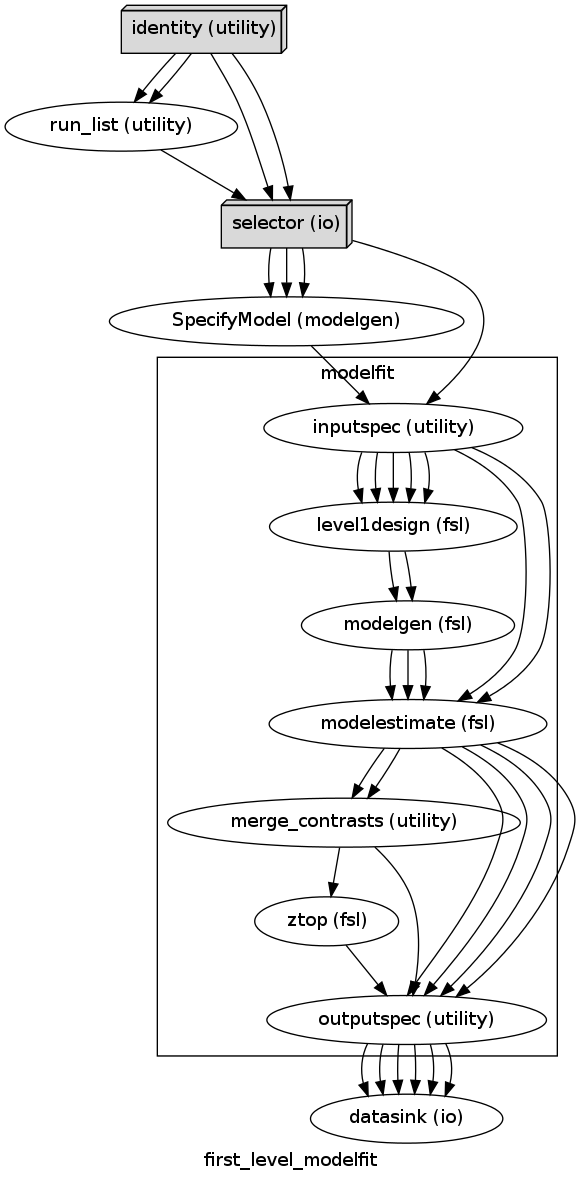

In [45]:
Image('/home/ysalzer1/fMRI/amc_Tactile_Simon_Study/workflow_folders/first_level_modelfit/graph.dot.png')

In [46]:
first_level_modelfit_workflow.run(plugin='MultiProc', plugin_args={'n_procs' : 8})

INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running in parallel.
INFO:workflow:Submitting 1 jobs
INFO:workflow:Executing: run_list.b0 ID: 0
INFO:workflow:[Job finished] jobname: run_list.b0 jobid: 0
INFO:workflow:Submitting 4 jobs
INFO:workflow:Executing: selector.aI.a2.b0 ID: 1
INFO:workflow:Executing: selector.aI.a1.b0 ID: 3
INFO:workflow:Executing: selector.aI.a0.b0 ID: 8
INFO:workflow:Executing node selector.aI.a2.b0 in dir: /home/ysalzer1/fMRI/amc_Tactile_Simon_Study/workflow_folders/first_level_modelfit/_modality_tactile_subject_id_001/_run_8/selector
INFO:workflow:Executing: selector.aI.a3.b0 ID: 25
INFO:workflow:Executing node selector.aI.a1.b0 in dir: /home/ysalzer1/fMRI/amc_Tactile_Simon_Study/workflow_folders/first_level_modelfit/_modality_tactile_subject_id_001/_run_7/selector
INFO:workflow:[Job finished] jobname: selector.aI.a2.b0 jobid: 1
INFO:workflow:Executing node selector.aI.a0.b0 in dir: /home/ysalzer1/fMRI/amc_Tactile_Simon_Study/workflow_folders/f

RuntimeError: Workflow did not execute cleanly. Check log for details


# Create Fixed effects workflow

In [ ]:
fixed_effects = create_fixed_effects_flow()

In [ ]:
for i in fixed_effects.inputs.inputspec.get():
    first_level_modelfit_workflow.connect(modelfit_workflow, 'outputspec.%s' % i, fixed_effects, '%s' % i)

In [ ]:
for i in fixed_effects.outputs.outputspec.get():
    first_level_modelfit_workflow.connect(fixed_effects, 'outputspec.%s' % i, datasink, '%s' % i)

In [ ]:
create_fixed_effects_flow()

# FSL.IMAGEMATH 
Change statistic maps from Z to p-value

# Create FDR Threshold work flow
take p-value image and use the FDR to carry out mulpitl correction. 

In [ ]:


#Think deeply on the contrasts I would like (pick into Gille's work)
# I am not sure how these are fed in without bfsl files...? 
#bfsl_files should be fed into the specifymodel module
#however, I do need to figure out how to merge the four runs together in once contrast (how did I do it before?) I guess this is how it works :)
#אולי הכי פשוט לעשות איטרציות על כל המשתנים מודליתי, ריצה, נבדק??
# אין לי כוונה להתחיל לבנות ספריות ותת ספריות באופן ידני- יתכן שאני טועה כאן בשיקול
#דבר נוסף שצירך לקחת בחשבון - המספרים של הריצות מתחלפים לסירוגנין 1-4 ו 5-8. גם כאן, זה צריך לרוץ אוטומטית ולהתעלם מכך שבמחצית המקרים הוא לא מוצאת מה שהוא מחפש.
